In [133]:
#calcuration libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import os
%matplotlib inline
import time
timestr = time.strftime("%d.%m.%Y_%H.%M.%S.")

In [134]:
#convert txt to csv file.
#Except folder!!!!!!!!!!!!!
for fname in os.listdir('pr10'):
    df = pd.read_table('./pr10/' + fname, encoding='shift_jis')
    df.to_csv('./pr10_csv/' + fname +'.csv')

In [135]:
# Material properties for Ethylen Glycol
A = 2.0148;
B = 4.50E-3;
def cp(T):
    cp = (A + B * (T+273.15));
    return cp
def cp_K(T):
    cp_K = A + B * (T);
    cp_K =  cp_K *1000;##???
    return cp_K

C = 0.2134;
D = 6.071E-4;
def Lambda(T):
    Lambda = C + D * (T+273.15);
    return Lambda
def Lambda_K(T):
    Lambda_K = C + D * (T);
    return Lambda_K

E = 1.1001E-4;
F = 325.85;
G = -207.30;
def mu(T):
    mu = E * np.exp( F / ( (T+273.15) + G) );
    return mu
def mu_K(T):
    mu_K = E * np.exp( F / ( (T) + G) );
    return mu_K

H = 1268.28;
I = -0.66;
def rho(T):
    rho = H + I * (T+273.15);
    return rho
def rho_K(T):
    rho_K = H + I * (T);
    return rho_K

def nu(T):
    nu = mu(T)/rho(T);
    return nu
def nu_K(T):
    nu_K = mu_K(T)/rho_K(T);
    return nu

def Pr(T):
    Pr = ( mu(T) * cp(T) * 1000 ) / Lambda(T);
    return Pr
def Pr_K(T):
    Pr_K = ( mu_K(T) * cp_K(T)) / Lambda_K(T);
    return Pr

# conduction equation for inner wall temperatuer 110-115
#Lambda_K = 0.16
DeltaK = 0.065E-3
Lambda_N = 20#!!!!!!!!!!!!!!!!!!!!!!!!
Lambda_C = 0.16 #thermal conductivity[W/mK] of capton tape
Lambda_iso = 0.055 #thermal conductivity[W/mK] of glass wool, outer isolation
riso = 0.05 #thickness of isolation????????????
#temperature distribution in pipe(ri << r << ra)
def T1(r,qv,qzu,TN,Ta):
    T1 = (qzu/(2*Lambda_N)*ra**2)*(0.5-0.5*(r/ra)**2+np.log(r/ra)) + Ta - qv/Lambda_N*(ra+DeltaK)*(Lambda_N/Lambda_C*np.log(ra/(ra+DeltaK))+np.log(r/ra))
    return T1
#temperature distribution in capton tape(ra << r << ra+DeltaK)
def T2(r,qv,Ta):
    T2 = - qv/Lambda_C*(ra+DeltaK)*np.log(r/(ra+DeltaK)) + Ta
    return T2

#definition
di=12E-3
da=15E-3
ri = di/2
ra = da/2
disoa = 90E-3
L=2
V=(da**2-di**2)*np.pi/4*L
Ageo_MS = di*np.pi*L #円菅内部の試験部表面積
Ugeo_MS = di*np.pi #円菅内面積
Ageo_quer = di**2*np.pi/4

# Definition der Temperaturen und MesspositionenCoeff_lf 148-203
#x_pos_TPt100_old = 
x_pos_TPt100_new = [0.030, 2.400, 2.600, 2.800, 3.000, 3.000, 3.140, 5.500]
#x_pos_TPt100_new_tmp = [0.030, 2.400, 2.600, 2.800, 3.000, 3.000, 3.140, 5.500]
#TPT100_new_tmp = [0,0,0,0,0]
xTin  = 0.03
xTout = 5.50
x_MS_in = 1.2
x_MS_out = 3.2

### read measurement data 6-115

In [136]:
filename_list = []
T_in_list = []
T_out_list = []
Tw_list = []
Tm_list = []
mdot_list = []
qw_list = []
Re_m_list = []
Re_w_list = []
ReTau_list = []
Pr_m_list = []
Pr_w_list = []
NuMessung_list = []
cf_M_list = []
delta_NuMessung_list = []
delta_cf_M_list = []

df_list_all = []


for fname in os.listdir('pr10_csv'):
    filename = './pr10_csv/' + fname
    if filename == './pr10_csv/.DS_Store':
        continue
    elif filename == './pr10_csv/.DS_Store.csv':
        continue
    else:
        #取り出したい列を（0始まりで）指定する．
        #filename = './pr50_csv/Daten_19.11.2018_15.34.54.csv'
        #data = np.array(pd.read_csv(filename, skiprows=0, encoding='shift-jis'))
        data = np.array(pd.read_csv(filename, header=None, skiprows=1))
        #print(filename)
        
        
        ####################################################################
        Tsa = data[:,1] #Temperatur aussen: Ts_aussen / °C
        Tsi = data[:,2] #Temperatur innen: Ts innen / °C
        Ti = data[:,3] #Fluidtemperatur: T / °C
        m_dot_C1 = data[0,4] #Massenstrom: m_dot C1 / kg/h
        m_dot_C2 = data[0,5] #Massenstrom: m_dot C2 / kg/h

        Re_C1 = data[0,6] #Re C1 / -
        Re_C2 = data[0,7] #Re C2 / -

        v_C1 = data[0,8] #Geschwindigkeit: v C1 / m/s
        v_C2 = data[0,9] #Geschwindigkeit: v C2 / m/s

        U_MS = data[0,10] #Spannungsabfall Messstrecke: U_MS / V
        I_MS = data[0,11] #Strom Messstrecke: I_MS / A
        P_MS = data[0,12] #Leistung Messstrecke: P_MS / W

        q = data[0,13] #spzifische Leistung: q / W/m3
        P1 = data[0,14] #Druckmessung: P1 / Pa
        P2 = data[0,15] #Druckmessung: P2 / Pa
        dp = data[0,16] #Differenzdruck: dp / bar
        nu_Fluid = data[0,17] #kin. Viscositaet Fluid: nu / m2/s
        rho_Fluid = data[0,18] #Dichte Fluid: rho / kg/m3
        Lambda_Fluid = data[0,19] #Waermeleitfaehigkeit Fluid: lambda / W/mK
        cp_Fluid = data[0,20] #spez. Waermekapazitaet Fluid: cp /J/kgK
        Pr_Fluid = data[0,21] #Pr / -
        Lambda_Rohr = data[0,22] #Waermeleitfaehigkeit Rohr: lambda / W/mK
        Nu_Fluid = data[0,23] #Nu / -

        I1 = data[0,24] #Strom I / A
        U1 = data[0,25] #Spannung U / V

        dp_T1 = data[0,26] #Re_tau / - 関数名とtxtが合っていない？
        dp_T2 = data[0,27] #Re_tau_Pet / -　関数名とtxtが合っていない？
        dp_T3 = data[0,28] #dp Pet / Pa

        #Mittel (U*I) mean P / W
        Pm = data[0,29] #Mittel (U*I) mean P / W
        TPT100_a_old = data[:5,30] #PT100 T aussen(5 value)
        TPT100_i_old = data[:5,31] #PT100 T innen(5 value)
        TPT100_m_old = data[:5,32] #PT100 T mittel(5 value)
        TPT100_a_new = data[:8,39]#!!!!!!!!!!!!!
        TPT100_i_new = data[:8,40]
        TPT100_m_new = data[:8,41]

        NuPt100 = data[0,33] #Nu Pt100
        NuQm = data[0,34] #Nu Qm

        # zeta computation Einlesen
        ZRem100 = data[0,35] #zeta Re
        Zzeta100 = data[0,36] #zeta
        Zqm100 = data[0,37] #zeta qw

        TPT100_T5 = data[0,38] #PT100 T5
        

        TPT100_out = TPT100_a_new
        TPT100_in  = TPT100_i_new
        TPT100_mean= TPT100_m_new
        
        TPT100_new = TPT100_i_new
        Tm_aus = TPT100_new[7]
        Tm = Tm_aus
        
        ####################################################################
        # iteration to update the temperatuer dependent material properties --> new wall temperature 205-339
        # first loop doesnt include dq heat loss.
        for i in range(2):
            Tw = TPT100_new[6]

            T_iso = Ti[1]
            T_inf = Ti[6]

            #Berechnung der Fluid Stoffwerte
            Pr_w = Pr(Tw)
            Pr_w     = Pr(Tw)
            rho_w    = rho(Tw)
            nu_w     = nu(Tw)
            mu_w     = nu_w * rho_w
            cp_w     = cp(Tw)
            Lambda_w = Lambda(Tw)
            Pr_m     = Pr(Tm)
            rho_m    = rho(Tm)
            nu_m     = nu(Tm)
            mu_m     = nu_m * rho_m
            cp_m     = cp(Tm)
            Lambda_m = Lambda(Tm)
            #Korrektur mittel Temperatur
            dqhldT = 1
            zeta_mischer = 32.46
            Thl = (Tw + Tm)*0.5 #!!!!!!!!!!!!!!!!
            qhl = dqhldT * (Thl - T_iso)

            qhlm2 = qhl / (da*np.pi*5.45)
            Re_m = Re_C1;
            Lambda_Pet = (1.8*np.log(Re_m)-1.5)**(-2) #Eq(4.17)
            
            #Specific heat capasity, cp mean
            T_in = TPT100_new[0] + 273.15
            T_out = TPT100_new[7] + 273.15
            Ac = 2.0148
            Bc = 4.50E-3
            cpm = (Ac*(T_out-T_in)+Bc/2*(T_out**2-T_in**2))/(T_out-T_in)*1000 #Eq(2.108)
            Wmean = Re_m*nu_m/di#velocisty?????
            mdot = m_dot_C1/3600
            
            #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            #x_pos_TPt100_new_tmp[0] = x_pos_TPt100_new[1]
            #x_pos_TPt100_new_tmp[1] = x_pos_TPt100_new[2]
            #x_pos_TPt100_new_tmp[2] = x_pos_TPt100_new[3]
            #x_pos_TPt100_new_tmp[3] = 0.5 * (x_pos_TPt100_new[4] + x_pos_TPt100_new[5])
            #x_pos_TPt100_new_tmp[4] = x_pos_TPt100_new[6]
            
            #TPT100_new_tmp[0] = TPT100_new[1]
            #TPT100_new_tmp[1] = TPT100_new[2]
            #TPT100_new_tmp[2] = TPT100_new[3]
            #TPT100_new_tmp[3] = 0.5 * (TPT100_new[4] + TPT100_new[5])
            #TPT100_new_tmp[4] = TPT100_new[6]
            
            #Different from Matlab!!!!!!
            fit = np.polyfit(x_pos_TPt100_new, TPT100_new,1)
            
            gradT_PT100 = fit[0]
            Q_Pt100 = gradT_PT100*mdot*cpm*L
            qUI = P_MS/Ageo_MS
            dqw2 = (Lambda_Pet*(5.45-2.92)/di + zeta_mischer) * rho_m * Wmean**2/2 * Wmean * Ageo_quer - qhl*(5.45-2.53)/5.45
            
            Qin_out = mdot*cpm*(T_out-T_in)
            dQ = Qin_out-P_MS
            
            #Q=m_dot * cp_m * DT
            gradT = (Qin_out/L) / (mdot * cpm )
            dTm = dqw2/(mdot*cpm)
            SA_Tm = gradT*(x_MS_out-x_pos_TPt100_new[6])
            
            Tm_aus = TPT100_new[7] - dTm
            Tm = Tm_aus - SA_Tm
            
            qw = Qin_out/ Ageo_MS
            if(Qin_out>0):
                qvA=qhlm2
                #print('qvA=qhlm2')
            else:
                qvA=0
                #print('qvA=0')
            
            Pr_w     = Pr(Tw)
            rho_w    = rho(Tw)
            nu_w     = nu(Tw)
            mu_w     = nu_w * rho_w
            cp_w     = cp(Tw)
            Lambda_w = Lambda(Tw)
            Pr_m     = Pr(Tm)
            rho_m    = rho(Tm)
            nu_m     = nu(Tm)
            mu_m     = nu_m * rho_m
            cp_m     = cp(Tm)
            Lambda_m = Lambda(Tm)
            
            #P_spez_m2 = P_MS/A;
            P=Pm
            P=P_MS
            #Reynolds number[-]
            Re_m = Re_C1
            Re_w = Re_C2
            Re_m = m_dot_C1/3600*4/(nu_m*rho_m*di*np.pi)
            Re_w = m_dot_C1/3600*4/(nu_w*rho_m*di*np.pi)
            
            #Wall temperature calibration
            qVol = Qin_out / V
            Tw = T1(ri,qvA,qVol,TPT100_a_new[6], TPT100_a_new[6])
            Tw_SA6 = T1(ri,qvA,qVol, TPT100_a_new[5], TPT100_a_new[5])
            Tw_SA5 = T1(ri,qvA,qVol, TPT100_a_new[4], TPT100_a_new[4])
            Tw_SA4 = T1(ri,qvA,qVol, TPT100_a_new[3], TPT100_a_new[3])
            Tw_SA3 = T1(ri,qvA,qVol, TPT100_a_new[2], TPT100_a_new[2])
            Tw_SA2 = T1(ri,qvA,qVol, TPT100_a_new[1], TPT100_a_new[1])
            Tw_SA1 = T1(ri,qvA,qVol, TPT100_a_new[0], TPT100_a_new[0])
            
            Tw_SA8 = T1(ri,qvA,qVol, TPT100_a_new[7], TPT100_a_new[7])
            
            TPT100_new[6] = Tw
            TPT100_new[0] = Tw_SA1
            TPT100_new[1] = Tw_SA2
            TPT100_new[2] = Tw_SA3
            TPT100_new[3] = Tw_SA4
            TPT100_new[4] = Tw_SA5
            TPT100_new[5] = Tw_SA6
            TPT100_new[7] = Tw_SA8
            
            Nu_QmdotCpDt_w = qw * di / (Lambda_w * (Tw-Tm ))
            NuMessung = Nu_QmdotCpDt_w
            
            tau_w = dp*di/(1*4)
            w_tau=(tau_w/rho_m)**(1/2) #share velocity
            ReTau = w_tau*di/nu_w
            cf_M = tau_w/(rho_m*Wmean**2/2) #Friction coefficient Eq(4.8)
               
        #桁数は四捨五入ではなく、「丸め」であることに注意
        #print('T','{:.4f}'.format(T_in), '{:.4f}'.format(T_out), '{:.4f}'.format(Tw), '{:.4f}'.format(Tm))
        #print('mdot', '{:.4f}'.format(mdot))
        #print('qw', '{:.4e}'.format(qw))
        print(filename)
        #print(dTm)
        print("Re[-]",'{:.4e}'.format(Re_m),'{:.4f}'.format(ReTau))
        #print('Pr[-]','{:.4f}'.format(Pr_w))
        #print('Nu','{:.4f}'.format(NuMessung))
        print('cf','{:.4f}'.format(cf_M))
        print('------------------')

        
        # Measurement uncertainty Ref. Bertsche2016
        #### absolute error
        #PT100 [K]
        T_e = 0.2
        #mass flow rate [kg / s]
        mdot_e = 0.20E-3 * mdot
        #pressure[Pa]
        p_e = 0.35E-3 * dp #dpでいいの???????????
        #density [kg / m^3]
        rho_e = 0.13
        #specific heat capasity [J / kg K]
        cp_e = 0.73
        #thermal conductivity of fluid [W / m K]
        Lambda_e = 1.56E-5
        
        
        #Uncertainty in each measurement influencing
        delta_mdot = (mdot_e / mdot)**2
        delta_cp = (cp_e/cp_m)**2 #cpm、cp_mどちら？
        delta_Lambda = (Lambda_e/Lambda_m)**2
        delta_T = (T_e/(T_in-Tm))**2 + ((T_e * (T_in-Tw)) / ((T_in-Tm)*(Tm-Tw)))**2 + (T_e/(Tm-Tw) )**2#T_outは影響しない？
        #Measurement uncertainty for NuMessung
        delta_NuMessung = (delta_mdot + delta_cp + delta_Lambda + delta_T)**(1/2) * NuMessung
        #Reduction of the uncertainty of the cp calibration is the most effective, in order to reduce the uncertainty of Nu.
        #print(delta_mdot)
        #print(delta_cp)#dominating part
        #print(delta_Lambda)
        #print(delta_T)
        #print(delta_NuMessung)
        
        #Uncertainty in each measurement influencing
        delta_p = (p_e / dp)**2
        delta_rho = (rho_e / rho_m)**2
        #Measurement uncertainty for cf_M
        delta_cf_M = (delta_p + delta_rho + (2*delta_mdot))**(1/2) * cf_M
        #Reduction of the uncertainty of the p calibration is the most effective, in order to reduce the uncertainty of cf.
        #print(delta_p)#dominating part
        #print(delta_rho)
        #print(delta_mdot)
        #print(delta_cf_M)
        
        filename_list.append(filename)
        T_in_list.append(T_in)
        T_out_list.append(T_out)
        Tw_list.append(Tw)
        Tm_list.append(Tm)
        mdot_list.append(mdot)
        qw_list.append(qw)
        Re_m_list.append(Re_m)
        Re_w_list.append(Re_w)
        ReTau_list.append(ReTau)
        Pr_m_list.append(Pr_m)
        Pr_w_list.append(Pr_w)
        NuMessung_list.append(NuMessung)
        cf_M_list.append(cf_M)
        delta_NuMessung_list.append(delta_NuMessung)
        delta_cf_M_list.append(delta_cf_M)

./pr10_csv/Daten_07.08.2019_15.32.14.txt.csv
Re[-] 4.6158e+03 362.4188
cf 0.0092
------------------
./pr10_csv/Daten_13.08.2019_15.26.09.txt.csv
Re[-] 1.4415e+04 911.9348
cf 0.0068
------------------
./pr10_csv/-Daten_08.08.2019_14.22.16.txt.csv
Re[-] 7.2006e+03 505.0006
cf 0.0084
------------------
./pr10_csv/Daten_07.08.2019_14.45.06.txt.csv
Re[-] 5.9565e+03 451.1911
cf 0.0095
------------------
./pr10_csv/-Daten_08.08.2019_17.20.14.txt.csv
Re[-] 1.4898e+04 930.0374
cf 0.0071
------------------
./pr10_csv/-Daten_08.08.2019_16.46.42.txt.csv
Re[-] 1.2441e+04 810.4176
cf 0.0077
------------------
./pr10_csv/Daten_08.08.2019_13.39.02.txt.csv
Re[-] 5.9577e+03 439.1242
cf 0.0090
------------------
./pr10_csv/Daten_08.08.2019_15.19.35.txt.csv
Re[-] 8.1360e+03 591.6765
cf 0.0092
------------------
./pr10_csv/Daten_07.08.2019_15.19.51.txt.csv
Re[-] 6.5154e+03 501.9349
cf 0.0096
------------------
./pr10_csv/Daten_13.08.2019_19.09.10.txt.csv
Re[-] 4.2319e+03 427.4627
cf 0.0125
----------------

### The aim of this code is to compare experimental data with empirical corrrelation suggested by Gnienlinski and Konakov.
\
Shadwed error bar->
Ref. https://stackoverflow.com/questions/12957582/plot-yerr-xerr-as-shaded-region-rather-than-error-bars

In [137]:
#SET HERE!!!!!!!!
Pr_correlation = 10

In [138]:
Re_lam = np.linspace(1,2300,)
Re_turb = np.linspace(2300,10000,)
#Skin friction for laminar flow
Cf_lam = 16 / Re_lam
#Skin friction for turbulent flow
Cf_Konakov =  0.25 * (1.8*np.log10(Re_turb) - 1.5)**(-2) #3000 < Re < 5*10^5, Eq(4.17) German literature!!!!
Cf_Petukhov =  0.25 * (1.8*np.log10(Re_turb) - 1.64)**(-2) #3000 < Re < 5*10^5, Eq(8.21) 違う！！！！
Cf_Blasius_a = 0.079 * Re_turb**(-1/4) #Re < 2*10^4, Eq(8.20a)
Cf_Blasius_b = 0.046 * Re_turb**(-1/5) #Re < 2*10^4, Eq(8.20b)
#Cf_Zagarola = #Turbulence Eq(6.35)

File name: ./recf_pr50.pdf


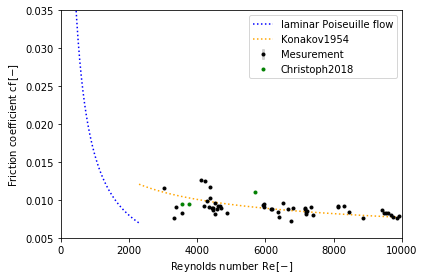

In [139]:
#plt.plot(Re_lam, Cf_lam, color='red')
plt.xlim(0,10000)
plt.ylim(0.005,0.035)
plt.plot(Re_lam, Cf_lam, color='blue',linestyle="dotted", label='laminar Poiseuille flow')
plt.plot(Re_turb, Cf_Konakov, color='orange',linestyle="dotted", label="Konakov1954")
#plt.plot(Re_turb, Cf_Petukhov, color='red',linestyle="dotted", label="Eq(8.21)")
#plt.plot(Re_turb, Cf_Blasius_a, color='green',linestyle="dotted",label='Moody diagram for smooth tube surface')
#plt.plot(Re_turb, Cf_Blasius_b, color='green',linestyle="dotted",label='Eq(8.20b)') 

plt.errorbar(Re_m_list, cf_M_list, delta_cf_M_list, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement");
#\plt.errorbar(ReTau_list, cf_M_list, delta_cf_M_list, fmt='.', color='black', ecolor='lightgray')

#Christoph2018
plt.errorbar(3571, 0.0095, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1, label="Christoph2018")
plt.errorbar(3773, 0.00943, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1)
plt.errorbar(5686, 0.011, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1)

plt.legend()
plt.xlabel(r'Reynolds number Re$\,\mathrm{[-]}$')
plt.ylabel(r'Friction coefficient cf$\,\mathrm{[-]}$')

#OutPutFig = './re_cf_pr50_'+ timestr + 'pdf'
OutPutFig = './recf_pr50.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)
print('File name:', OutPutFig)

In [140]:
Re_lam = np.linspace(1,2300,)
Re_tran = np.linspace(2300,10000,)
Re_turb = np.linspace(10000,100000,)

In [141]:
#laminar
Nu_lam1 = 3.66
Nu_lam2 = 0.7
Nu_lam3 = 1.615 * (Re_lam * Pr_correlation * di / L)**(1/3)
Nu_lam = (Nu_lam1**3 + Nu_lam2**3 + Nu_lam3**3)**(1/3)
#turbulent
xi = (1.8 * np.log10(Re_turb) - 1.5)**(-2)
Nu_turb = ((xi/8 * Re_turb * Pr_correlation) / (1 + 12.7 * (xi/8)**0.5 * (Pr_correlation**(2/3) - 1))) * (1 + (di/L)**(2/3))
#transitional
c1 = Nu_lam[49]
c2 = Nu_turb[0]
r = (Re_tran - 2300) / (10**4 - 2300)
Nu_tran = (1 - r) * c1 + r * c2

File name: ./renu_pr50.pdf


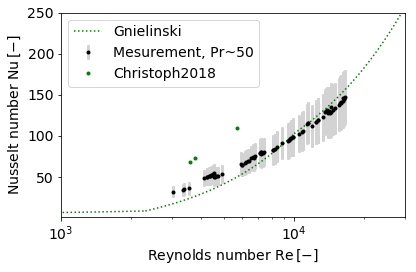

In [143]:
#plt.xlim(500,20000)
#plt.ylim(1,1000)
#plt.loglog(Re_lam, Nu_lam * 1.15, color='blue',linestyle="dotted", label="+-15% to Gnielinski for laminar")
#plt.loglog(Re_lam, Nu_lam * 0.85, color='blue',linestyle="dotted")
#plt.loglog(Re_tran, Nu_tran * 1.15, color='orange',linestyle="dotted", label="+-15% to Gnielinski for transitional")
#plt.loglog(Re_tran, Nu_tran * 0.85, color='orange',linestyle="dotted")
#plt.loglog(Re_turb, Nu_turb * 1.15, color='red',linestyle="dotted", label="+-15% to Gnielinski for turbulent")
#plt.loglog(Re_turb, Nu_turb * 0.85, color='red',linestyle="dotted")


plt.xlim(1000,30000)
plt.ylim(1,250)
plt.semilogx(Re_lam, Nu_lam, color='green',linestyle="dotted", label="Gnielinski")
plt.semilogx(Re_tran, Nu_tran, color='green',linestyle="dotted")#, label="Gnielinski for transitional")
plt.semilogx(Re_turb, Nu_turb, color='green',linestyle="dotted")#, label="Gnielinski for turbulent")
#plt.semilogx(Re_turb, NuDB, color='blue',linestyle="dotted", label="Dittus-Boelter")
#plt.semilogx(Re_turb, Nu_Robinson, color='red',linestyle="dotted", label="K.Robinson2003 without roughness factor, pr10")
#plt.errorbar(Re_pr10, Nu_pr10, fmt='.', color='dimgray', elinewidth=3, capsize=1, label="Bertsche2016, pr10")





plt.errorbar(Re_m_list, NuMessung_list, delta_NuMessung_list, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr~50")

#Christoph2018
plt.errorbar(3571, 68, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1, label="Christoph2018")
plt.errorbar(3773, 73, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1)
plt.errorbar(5686, 110, fmt='.', color='green', ecolor='lightgreen', elinewidth=3, capsize=1)

plt.xlabel(r'Reynolds number Re$\,\mathrm{[-]}$')
plt.ylabel(r'Nusselt number Nu$\,\mathrm{[-]}$')

#ax.legend([Nu_lam * 1.15, Nu_tran], ['A', 'B'])
plt.legend(loc='upper left')

plt.rcParams["font.size"] = 14

#OutPutFig = './re_nu_pr50_'+ timestr + 'pdf'
OutPutFig = './renu_pr50.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

print('File name:', OutPutFig)